In [1]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.5 MB/s eta 0:00:00


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
from datasets import load_dataset
dataset = load_dataset("sentence-transformers/squad")

README.md:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 87599
    })
})

In [5]:
from sentence_transformers import SentenceTransformer

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [6]:
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
import torch

In [9]:
device = torch.device("cuda")
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [10]:
questions = dataset['train']['question']
answers = dataset['train']['answer']
answers = list(set(answers))

In [11]:
question_embeddings = model.encode(questions, convert_to_tensor=True)
answer_embeddings = model.encode(answers, convert_to_tensor=True)

print("Osadzenia zapytań:", question_embeddings.shape)
print("Osadzenia odpowiedzi:", answer_embeddings.shape)

Osadzenia zapytań: torch.Size([87599, 768])
Osadzenia odpowiedzi: torch.Size([18891, 768])


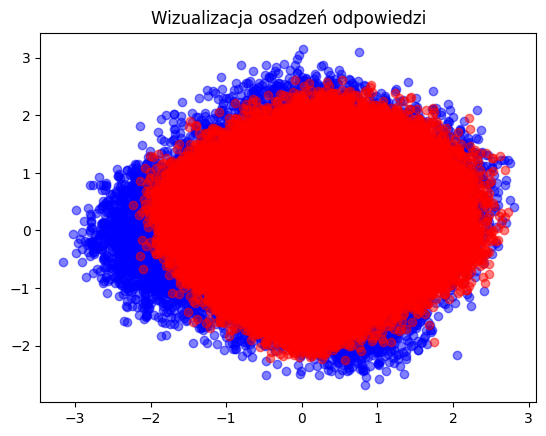

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_embeddings_a = pca.fit_transform(answer_embeddings.cpu().numpy())
reduced_embeddings_q = pca.fit_transform(question_embeddings.cpu().numpy())

plt.scatter(reduced_embeddings_a[:, 0], reduced_embeddings_a[:, 1], alpha=0.5, color="blue")
plt.scatter(reduced_embeddings_q[:, 0], reduced_embeddings_q[:, 1], alpha=0.5, color="red")

plt.title("Wizualizacja osadzeń odpowiedzi")
plt.show()

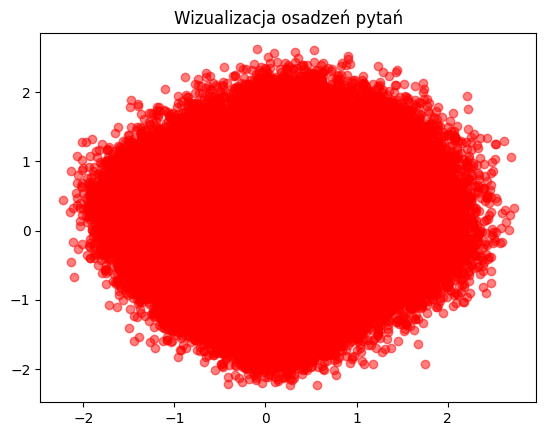

In [35]:
pca = PCA(n_components=2)
reduced_embeddings_a = pca.fit_transform(answer_embeddings.cpu().numpy())
reduced_embeddings_q = pca.fit_transform(question_embeddings.cpu().numpy())

plt.scatter(reduced_embeddings_q[:, 0], reduced_embeddings_q[:, 1], alpha=0.5, color="red")
plt.title("Wizualizacja osadzeń pytań")
plt.show()

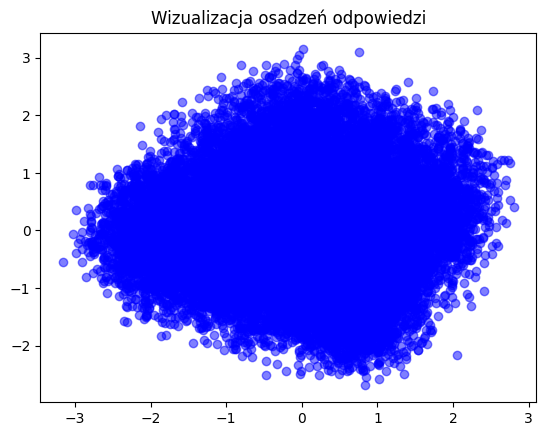

In [36]:
plt.scatter(reduced_embeddings_a[:, 0], reduced_embeddings_a[:, 1], alpha=0.5, color="blue")
plt.title("Wizualizacja osadzeń odpowiedzi")
plt.show()

In [13]:
top_k = 5

for question in questions[:10]:
  question_embedding = model.encode(question, convert_to_tensor=True)
  similarity_scores = model.similarity(question_embedding, answer_embeddings)[0]
  scores, indices = torch.topk(similarity_scores, k=top_k)

  print("\nQuery:", question)
  print("Top 5 most similar sentences in corpus:")

  for score, idx in zip(scores, indices):
      print(answers[idx], f"(Score: {score:.4f})")


Query: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Top 5 most similar sentences in corpus:
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary. (Score: 21.6458)
The Gospel of Luke begins its account of Mary's life with the Annunciation, when the angel Gabriel appeared to her and announced her divine selection to be the mother 

In [30]:
sample_question = questions[8]
sample_q_em = model.encode(sample_question, convert_to_tensor=True)
sample_q_em.shape

torch.Size([768])

In [31]:
similarity_scores = model.similarity(sample_q_em, answer_embeddings)[0]
top_results = torch.topk(similarity_scores, k=top_k)

In [32]:
top_answers = [answers[idx] for idx in top_results[1].cpu().numpy()]
top_embeddings = [answer_embeddings[idx].cpu().numpy() for idx in top_results[1].cpu().numpy()]

In [33]:
import numpy as np
all_embeddings = np.vstack([sample_q_em.cpu().numpy()] + top_embeddings)

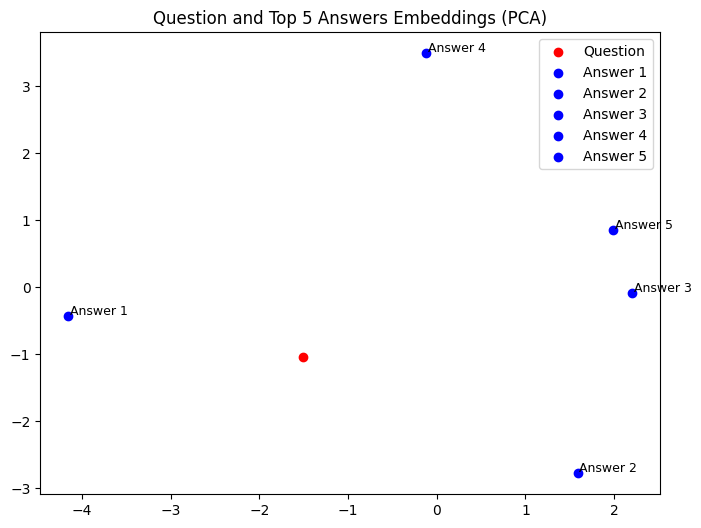

In [34]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[0, 0], reduced_embeddings[0, 1], color='red', label='Question')
for i, (x, y) in enumerate(reduced_embeddings[1:]):
    plt.scatter(x, y, color='blue', label=f'Answer {i+1}')
    plt.text(x + 0.02, y + 0.02, f'Answer {i+1}', fontsize=9)

plt.title('Question and Top 5 Answers Embeddings (PCA)')
plt.legend()
plt.show()

In [37]:
answer_embeddings_np = np.array([emb.cpu().numpy() for emb in answer_embeddings])


In [38]:
import faiss


In [40]:
faiss.normalize_L2(answer_embeddings_np)

dimension = answer_embeddings_np.shape[1]
index = faiss.IndexFlatIP(dimension)

index.add(answer_embeddings_np)

question_embedding_np = sample_q_em.cpu().numpy()
faiss.normalize_L2(question_embedding_np.reshape(1, -1))
D, I = index.search(question_embedding_np.reshape(1, -1), k=5)

top_answers = [answers[idx] for idx in I[0]]
top_scores = D[0]
print(sample_question)
for i, (answer, score) in enumerate(zip(top_answers, top_scores)):
    print(f"Top {i+1} Answer: {answer}, Score: {score}")

How many student news papers are found at Notre Dame?
Top 1 Answer: As at most other universities, Notre Dame's students run a number of news media outlets. The nine student-run outlets include three newspapers, both a radio and television station, and several magazines and journals. Begun as a one-page journal in September 1876, the Scholastic magazine is issued twice monthly and claims to be the oldest continuous collegiate publication in the United States. The other magazine, The Juggler, is released twice a year and focuses on student literature and artwork. The Dome yearbook is published annually. The newspapers have varying publication interests, with The Observer published daily and mainly reporting university and other news, and staffed by students from both Notre Dame and Saint Mary's College. Unlike Scholastic and The Dome, The Observer is an independent publication and does not have a faculty advisor or any editorial oversight from the University. In 1987, when some students